In [43]:
# Some imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from matplotlib.dates import DateFormatter
from dateutil import tz

In [44]:
def load_historic_weather_data():
    #https://mesonet.agron.iastate.edu/request/download.phtml?network=NY_ASOS
    weather_url = 'https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=JFK&tz=Etc%2FUTC&data=tmpc&data=dwpc&data=relh&data=drct&data=sped&data=mslp&data=p01m&data=vsby&data=gust_mph&data=peak_wind_gust_mph&year1=2000&month1=1&day1=1&year2=2025&month2=12&day2=31&format=onlycomma&latlon=no&missing=empty&trace=empty&direct=no&report_type=1&report_type=2'
    w_df = pd.read_csv(weather_url)
    w_df = w_df[pd.notnull(w_df['tmpc'])]
    w_df['datetime'] = pd.to_datetime(w_df['valid'], format='%Y-%m-%d %H:%M', errors='ignore')
    w_df['datetime'] = w_df['datetime'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    drop_arr = []
    for index, row in w_df.iterrows():
        if row['datetime'].minute != 51:
            drop_arr.append(index)
        else:
            w_df.at[index, 'datetime'] = row['datetime'] - timedelta(minutes=51)
    w_df.drop(drop_arr, inplace=True)
    w_df = w_df.drop_duplicates(subset=['datetime'])
    w_df.rename(columns={'p01m': 'precipitation_mm',
                         'sped': 'wind_speed_mph',
                         'relh': 'rh_percentage',
                         'tmpc': 'temp_celcius',
                         'dwpc': 'dewp_celcius',
                         'drct': 'wind_dir',
                         'mslp': 'sea_level_pressure_mb',
                         'vsby': 'visibility_miles'
                        }, inplace=True)
    return w_df

In [45]:
# Loading weather data
weather_data = load_historic_weather_data()

In [46]:
# Checking the latest entries
weather_data.tail()

,station,valid,temp_celcius,dewp_celcius,rh_percentage,wind_dir,wind_speed_mph,sea_level_pressure_mb,precipitation_mm,visibility_miles,gust_mph,peak_wind_gust_mph,datetime
644742,JFK,2020-08-25 13:51,27.78,20.00,62.62,250.0,11.50,1009.9,0.0,10.0,NaN,NaN,2020-08-25 09:00:00-04:00
644753,JFK,2020-08-25 14:51,29.39,20.00,57.02,260.0,13.80,1009.4,0.0,10.0,NaN,NaN,2020-08-25 10:00:00-04:00
644764,JFK,2020-08-25 15:51,31.72,18.28,44.80,280.0,14.95,1009.2,0.0,10.0,19.55,NaN,2020-08-25 11:00:00-04:00
644776,JFK,2020-08-25 16:51,31.72,17.78,43.42,260.0,16.10,1008.3,0.0,10.0,NaN,NaN,2020-08-25 12:00:00-04:00
644788,JFK,2020-08-25 17:51,32.22,18.28,43.55,260.0,14.95,1007.8,0.0,10.0,NaN,NaN,2020-08-25 13:00:00-04:00


In [47]:
# Weather data on Aug 22nd
aug22_weatherdata = weather_data[(weather_data['datetime'] >= '2020-08-22 06:00') & (weather_data['datetime'] <= '2020-08-23 06:00')]

In [50]:
aug22_weatherdata.head()

,station,valid,temp_celcius,dewp_celcius,rh_percentage,wind_dir,wind_speed_mph,sea_level_pressure_mb,precipitation_mm,visibility_miles,gust_mph,peak_wind_gust_mph,datetime
643781,JFK,2020-08-22 10:51,23.28,21.11,87.63,240.0,8.05,1013.7,0.0,10.0,NaN,NaN,2020-08-22 06:00:00-04:00
643794,JFK,2020-08-22 11:51,23.89,21.11,84.46,230.0,10.35,1013.8,0.0,10.0,NaN,NaN,2020-08-22 07:00:00-04:00
643807,JFK,2020-08-22 12:51,25.00,22.22,84.58,240.0,9.20,1013.7,0.0,10.0,NaN,NaN,2020-08-22 08:00:00-04:00
643820,JFK,2020-08-22 13:51,25.61,22.22,81.55,230.0,10.35,1014.2,0.0,10.0,NaN,NaN,2020-08-22 09:00:00-04:00
643833,JFK,2020-08-22 14:51,27.22,22.78,76.70,220.0,9.20,1014.3,0.0,10.0,NaN,NaN,2020-08-22 10:00:00-04:00


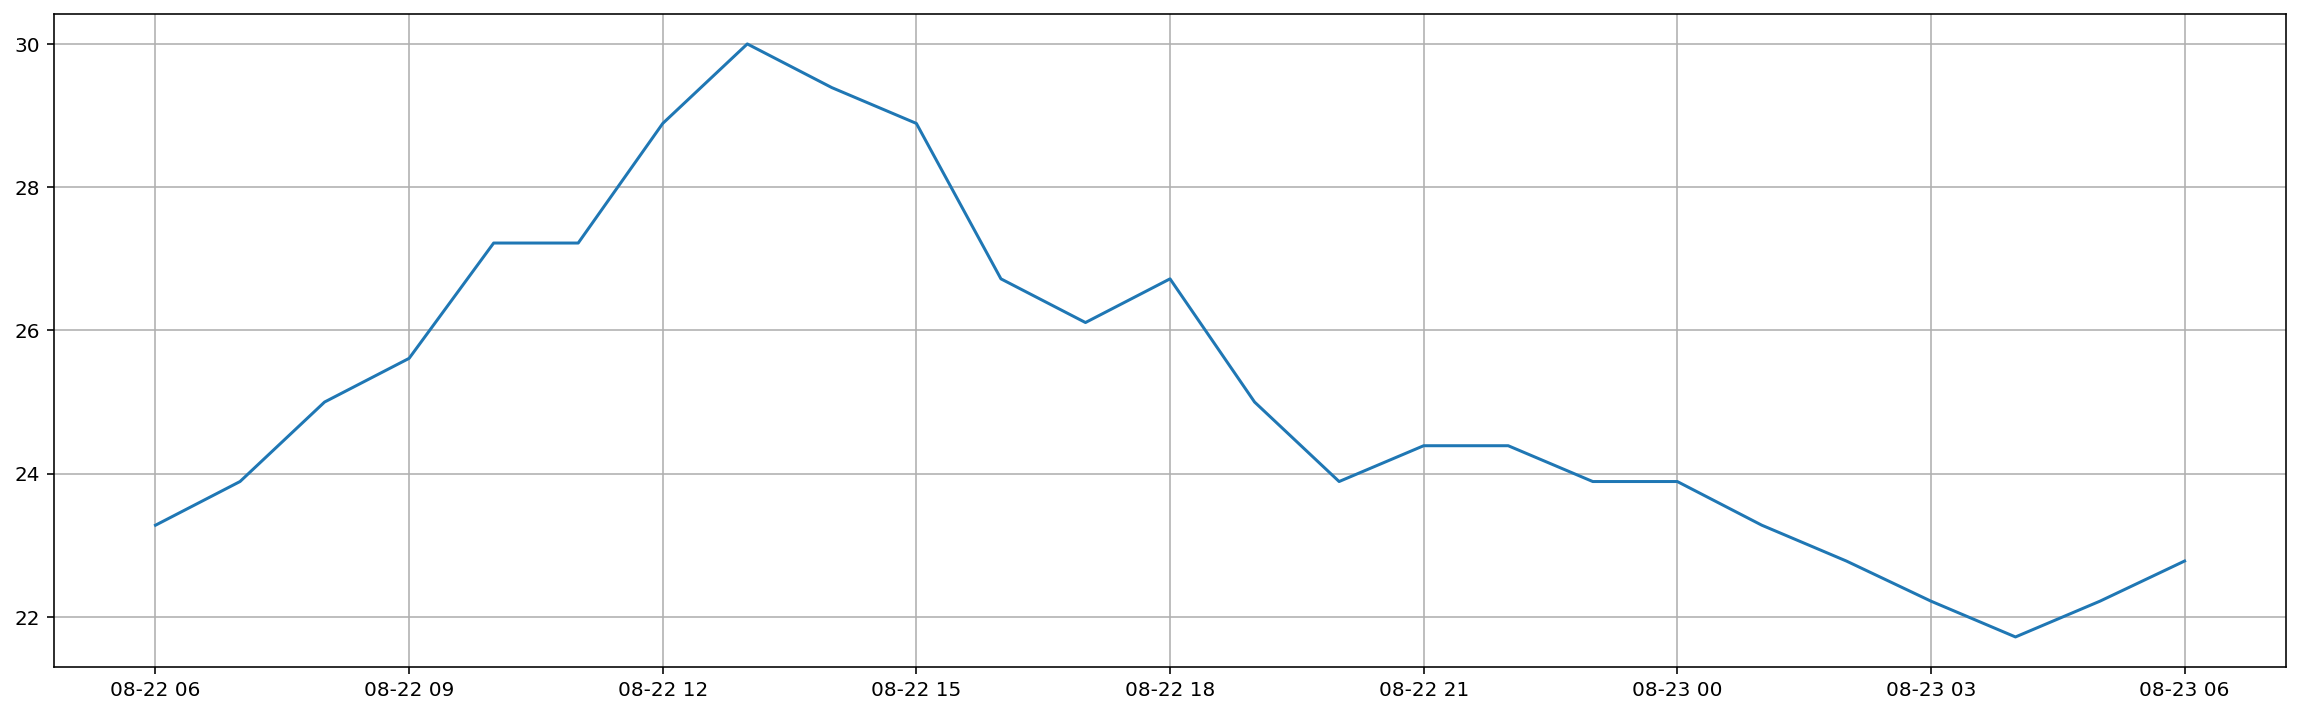

In [51]:
plt.figure(figsize = (20, 6))
plt.plot(aug22_weatherdata["datetime"],aug22_weatherdata["temp_celcius"])
plt.grid(True)

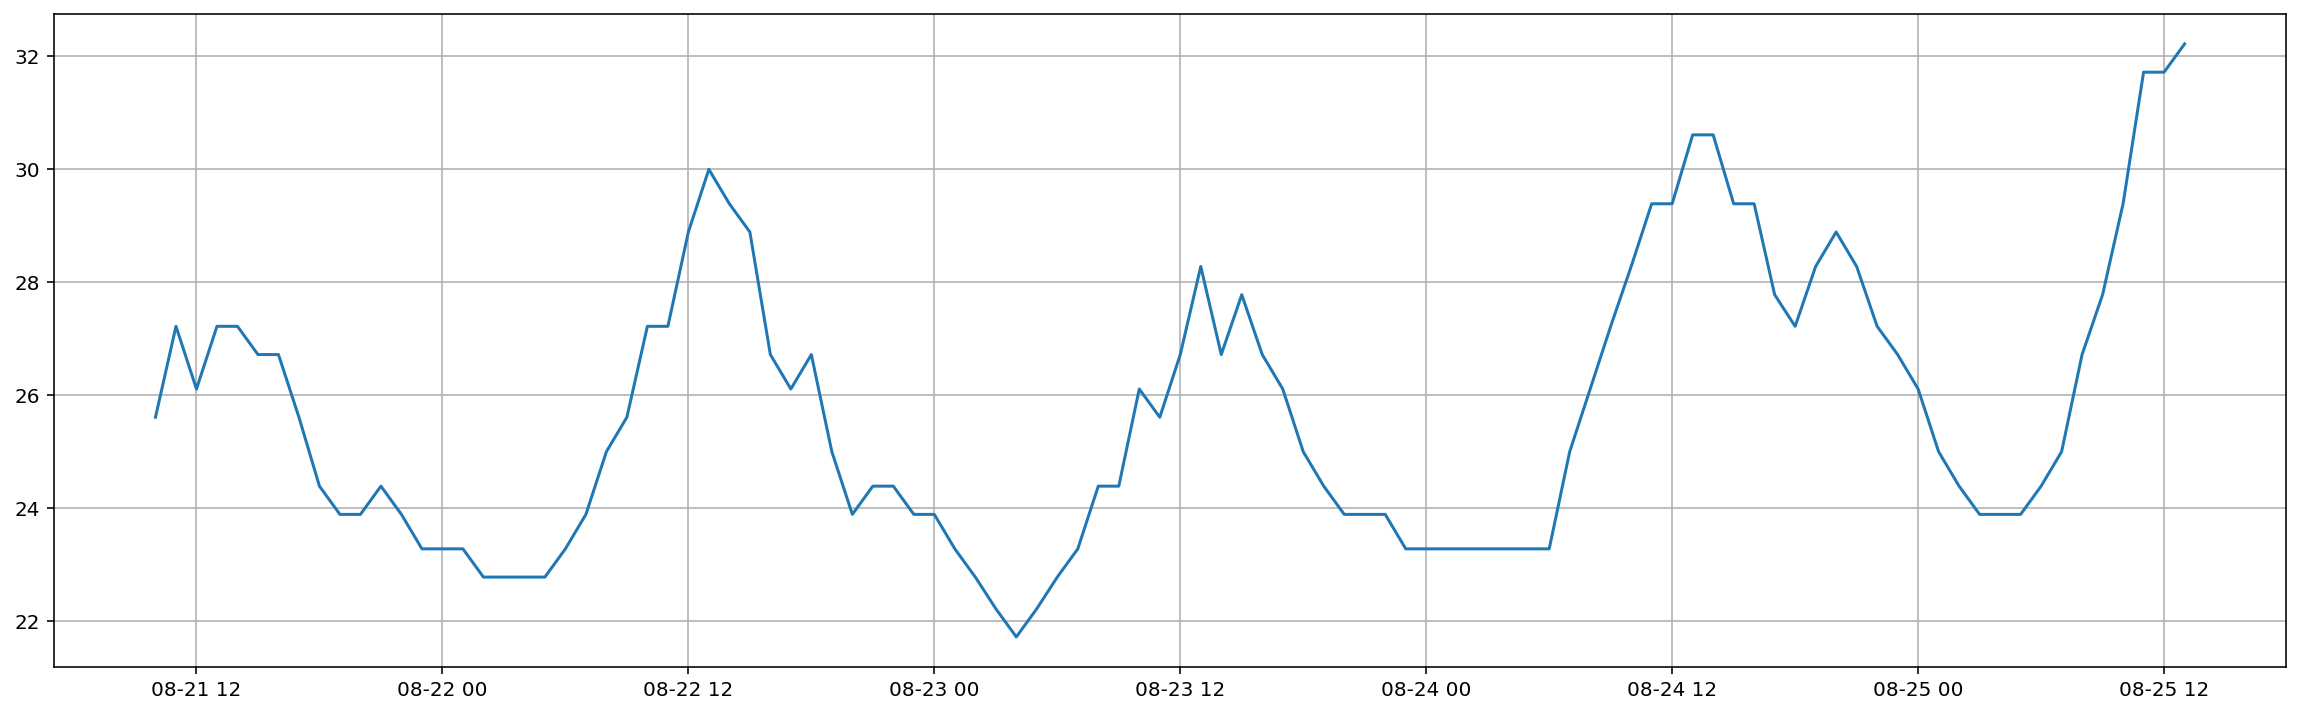

In [52]:
plt.figure(figsize = (20, 6))
plt.plot(weather_data.tail(100)["datetime"],weather_data.tail(100)["temp_celcius"])
plt.grid(True)

In [55]:
# Sensor Data Aug22nd
doc = '/content/Aug22nd.csv'
depth_   = []
with open(doc,'r') as ff:
    for line in ff:        
        if '2020' in line:
            temp = line.split(',')
            if (temp[1]!=0):
              temp[3] = temp[3].replace('\n','')
              temp[3] = temp[3].replace(' UTC','')
              depth_.append([temp[3],temp[1]])  

depth_readings = pd.DataFrame(depth_, columns = ['time','depth'])  
depth_readings["depth"] = pd.to_numeric(depth_readings["depth"], downcast="float")

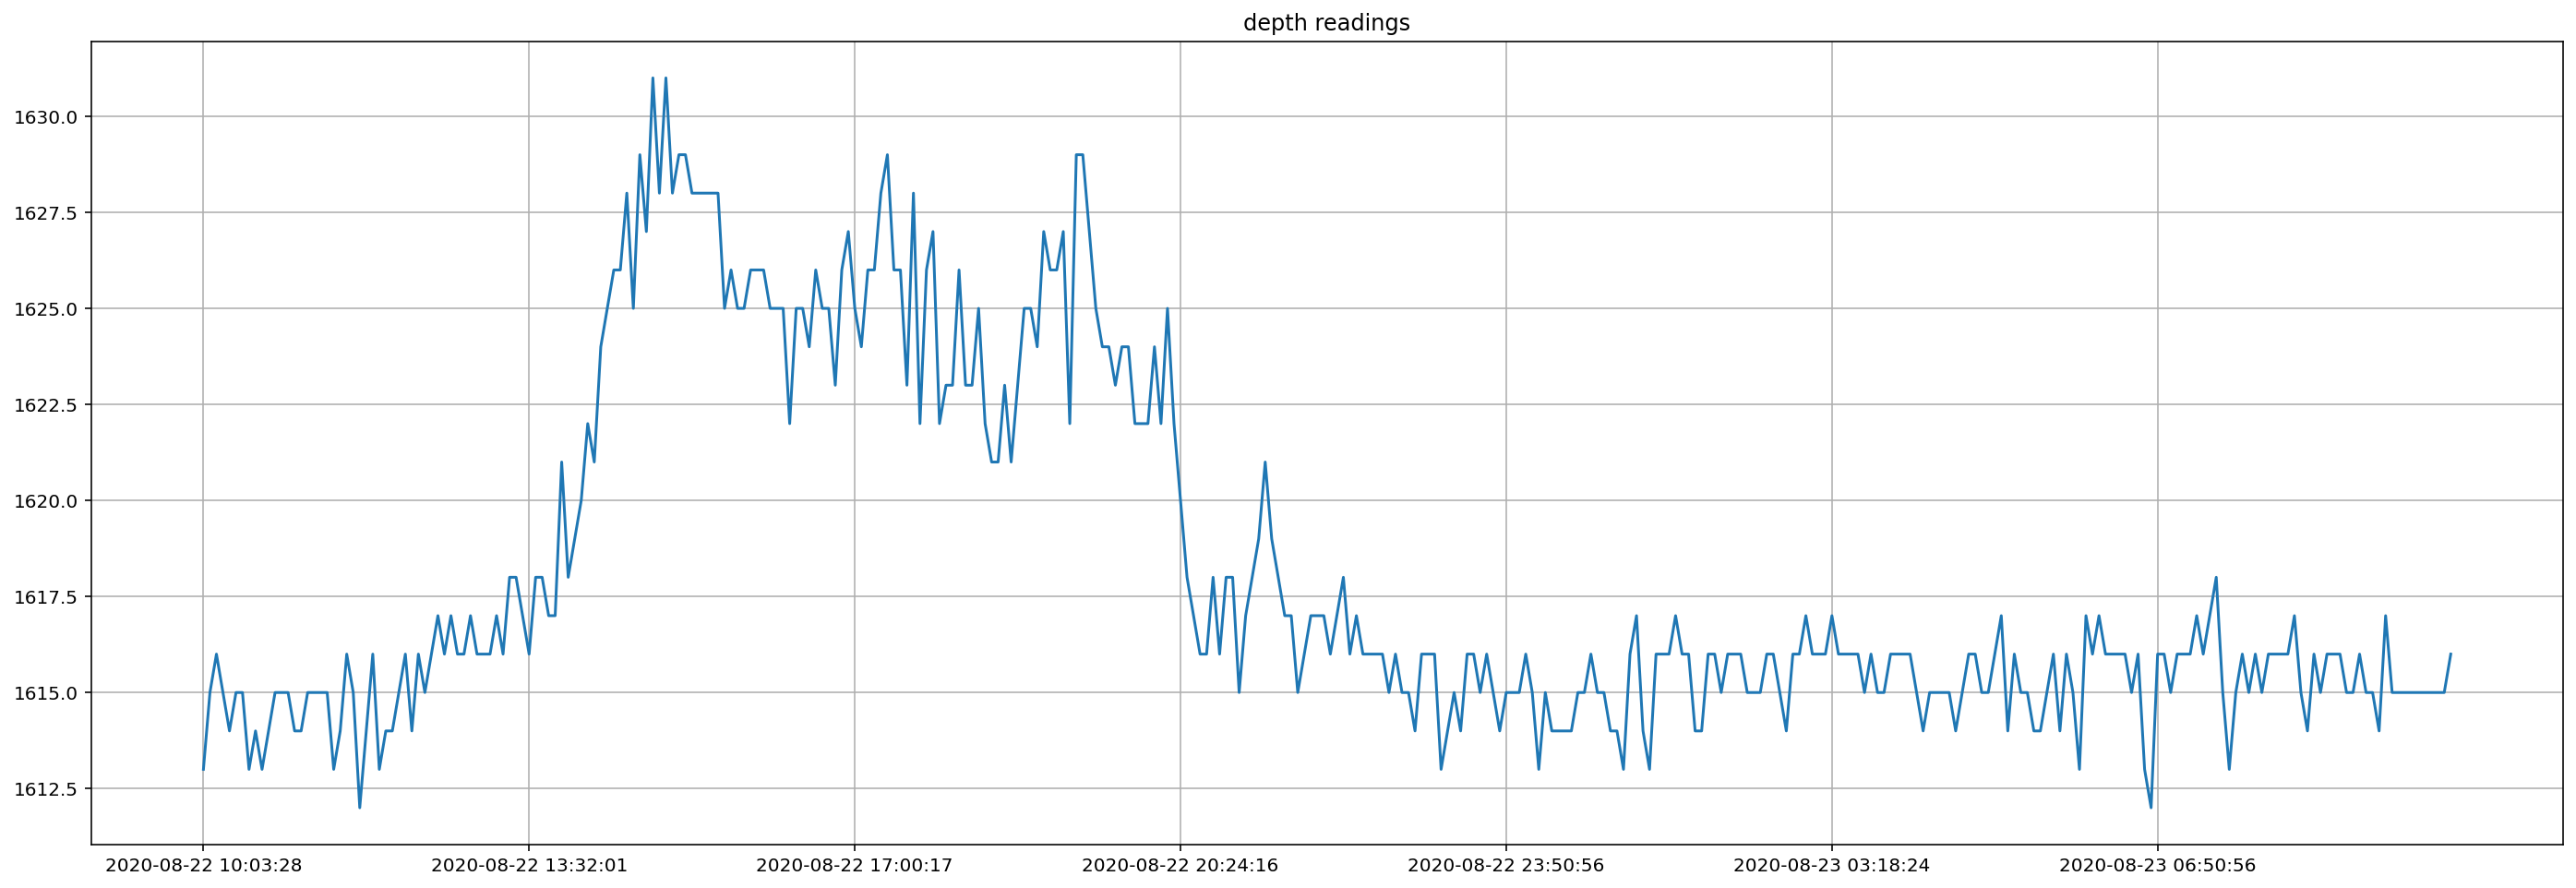

In [56]:
#Plot the readings
a = np.arange(0,depth_readings.shape[0])
plt.figure(figsize = (24, 8))
plt.plot(a,depth_readings['depth'])
plt.title('depth readings')
ticks = np.arange(0,depth_readings.shape[0],step=50)
labels = depth_readings["time"][0::50]
plt.xticks(ticks, labels) 
plt.grid(True)

In [57]:
# The timestamps are UTC, converting to EST
depth_readings["time"] = pd.to_datetime(depth_readings["time"], format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
depth_readings["time"].dt.tz
depth_readings["time"] = depth_readings["time"].dt.tz_localize('UTC')
depth_readings["time"] = depth_readings["time"].dt.tz_convert('US/Eastern')
depth_readings

,time,depth
0,2020-08-22 06:03:28-04:00,1613.0
1,2020-08-22 06:07:39-04:00,1615.0
2,2020-08-22 06:11:50-04:00,1616.0
3,2020-08-22 06:16:01-04:00,1615.0
4,2020-08-22 06:20:12-04:00,1614.0
...,...,...
341,2020-08-23 05:42:10-04:00,1615.0
342,2020-08-23 05:46:21-04:00,1615.0
343,2020-08-23 05:50:31-04:00,1615.0
344,2020-08-23 05:54:42-04:00,1615.0


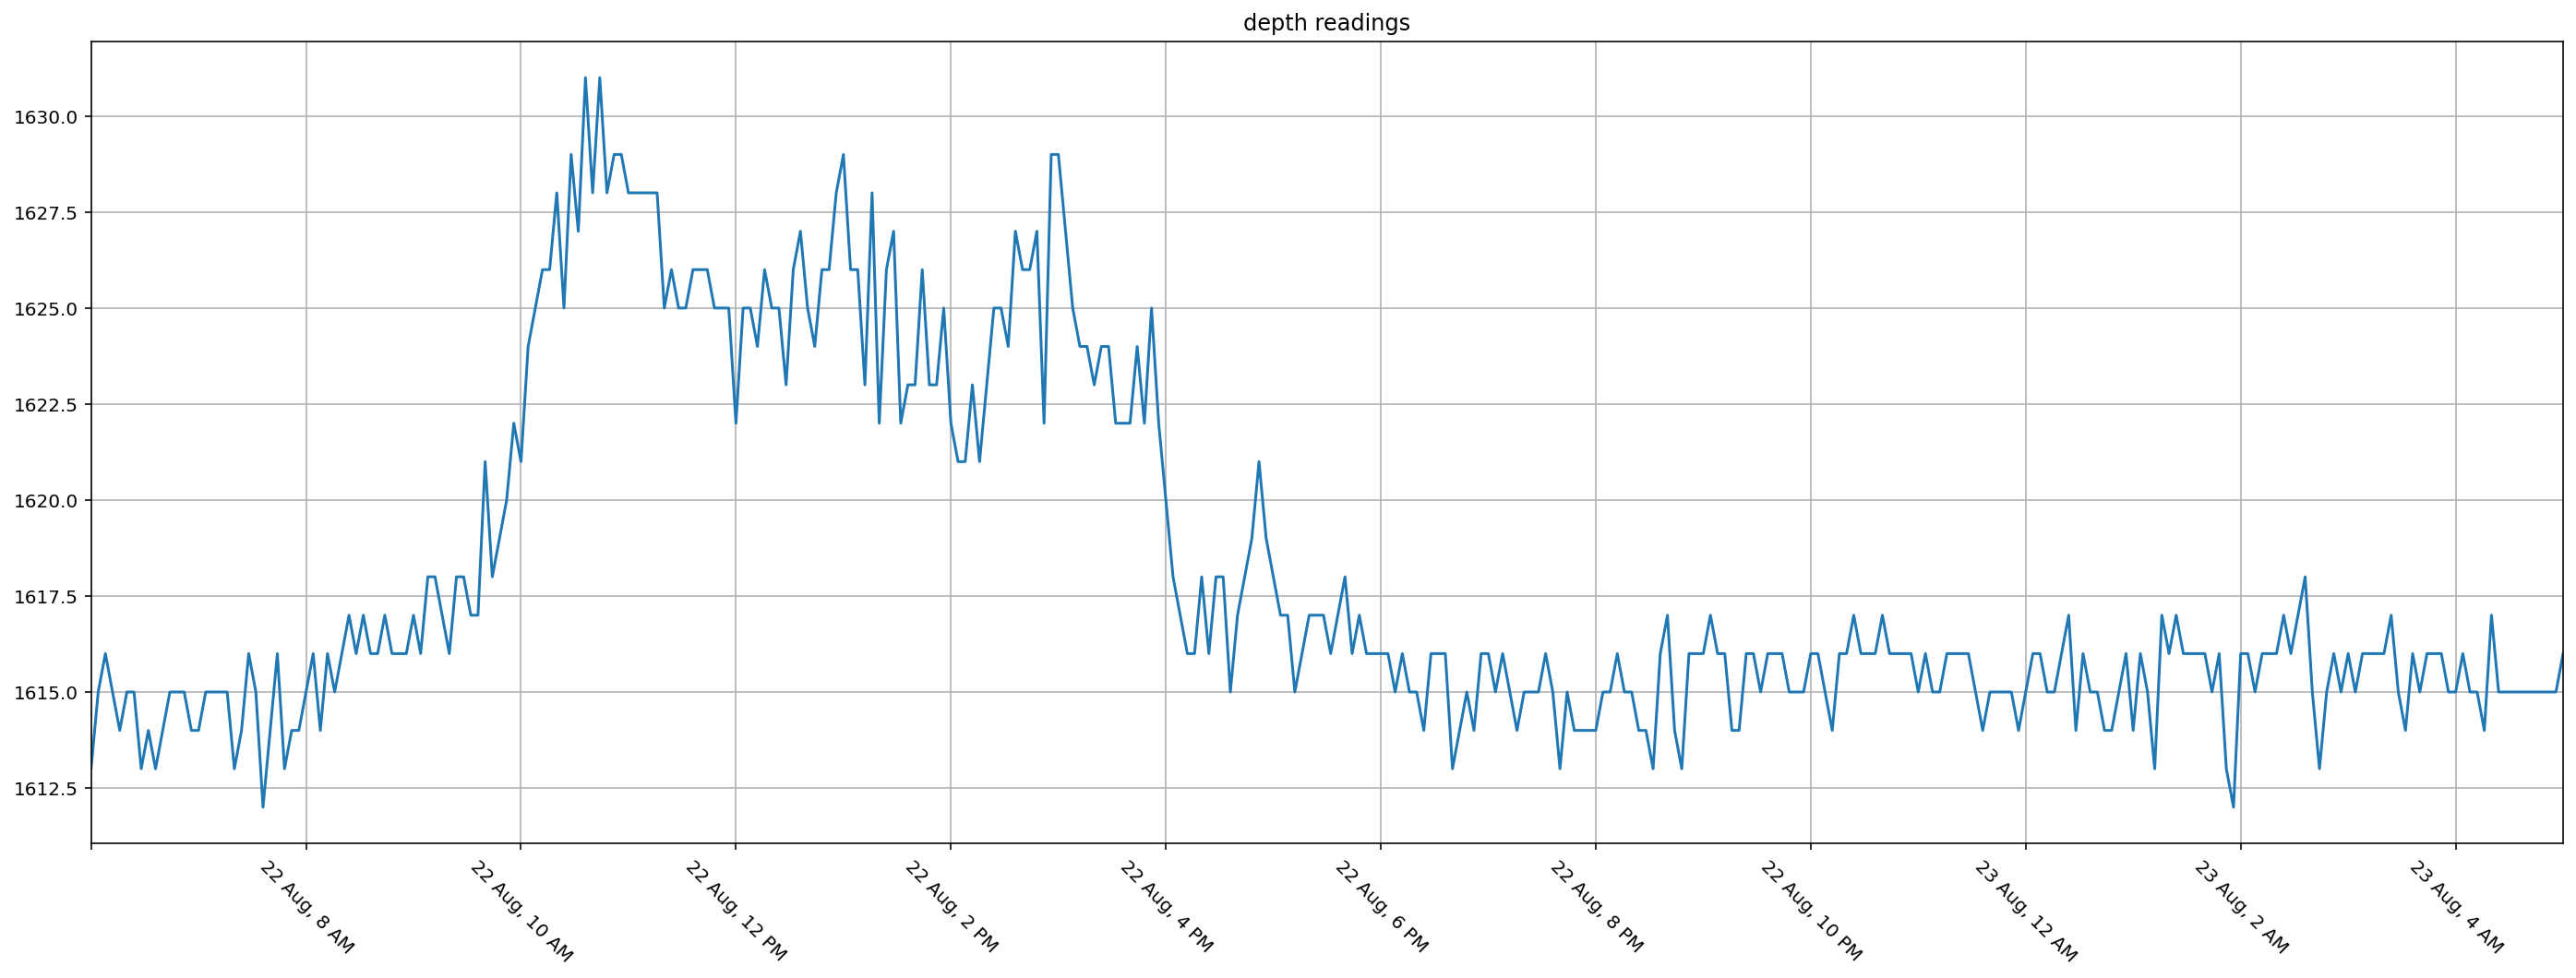

In [58]:
# Plotting readings once more
labels = depth_readings["time"][0::30]
cust_labels = []
for i in labels:
  ts = pd.to_datetime(str(i)) 
  d = ts.strftime("%d %b, %-I %p")
  cust_labels.append(d)
a = np.arange(0,depth_readings.shape[0])
plt.figure(figsize = (24, 8))
plt.plot(a,depth_readings['depth'])
plt.title('depth readings')
ticks = np.arange(0,depth_readings.shape[0],step=30)
cust_labels[0] = ''
plt.xticks(ticks, cust_labels, rotation = -45) 
plt.xlim(0,a.max())
plt.grid(True)

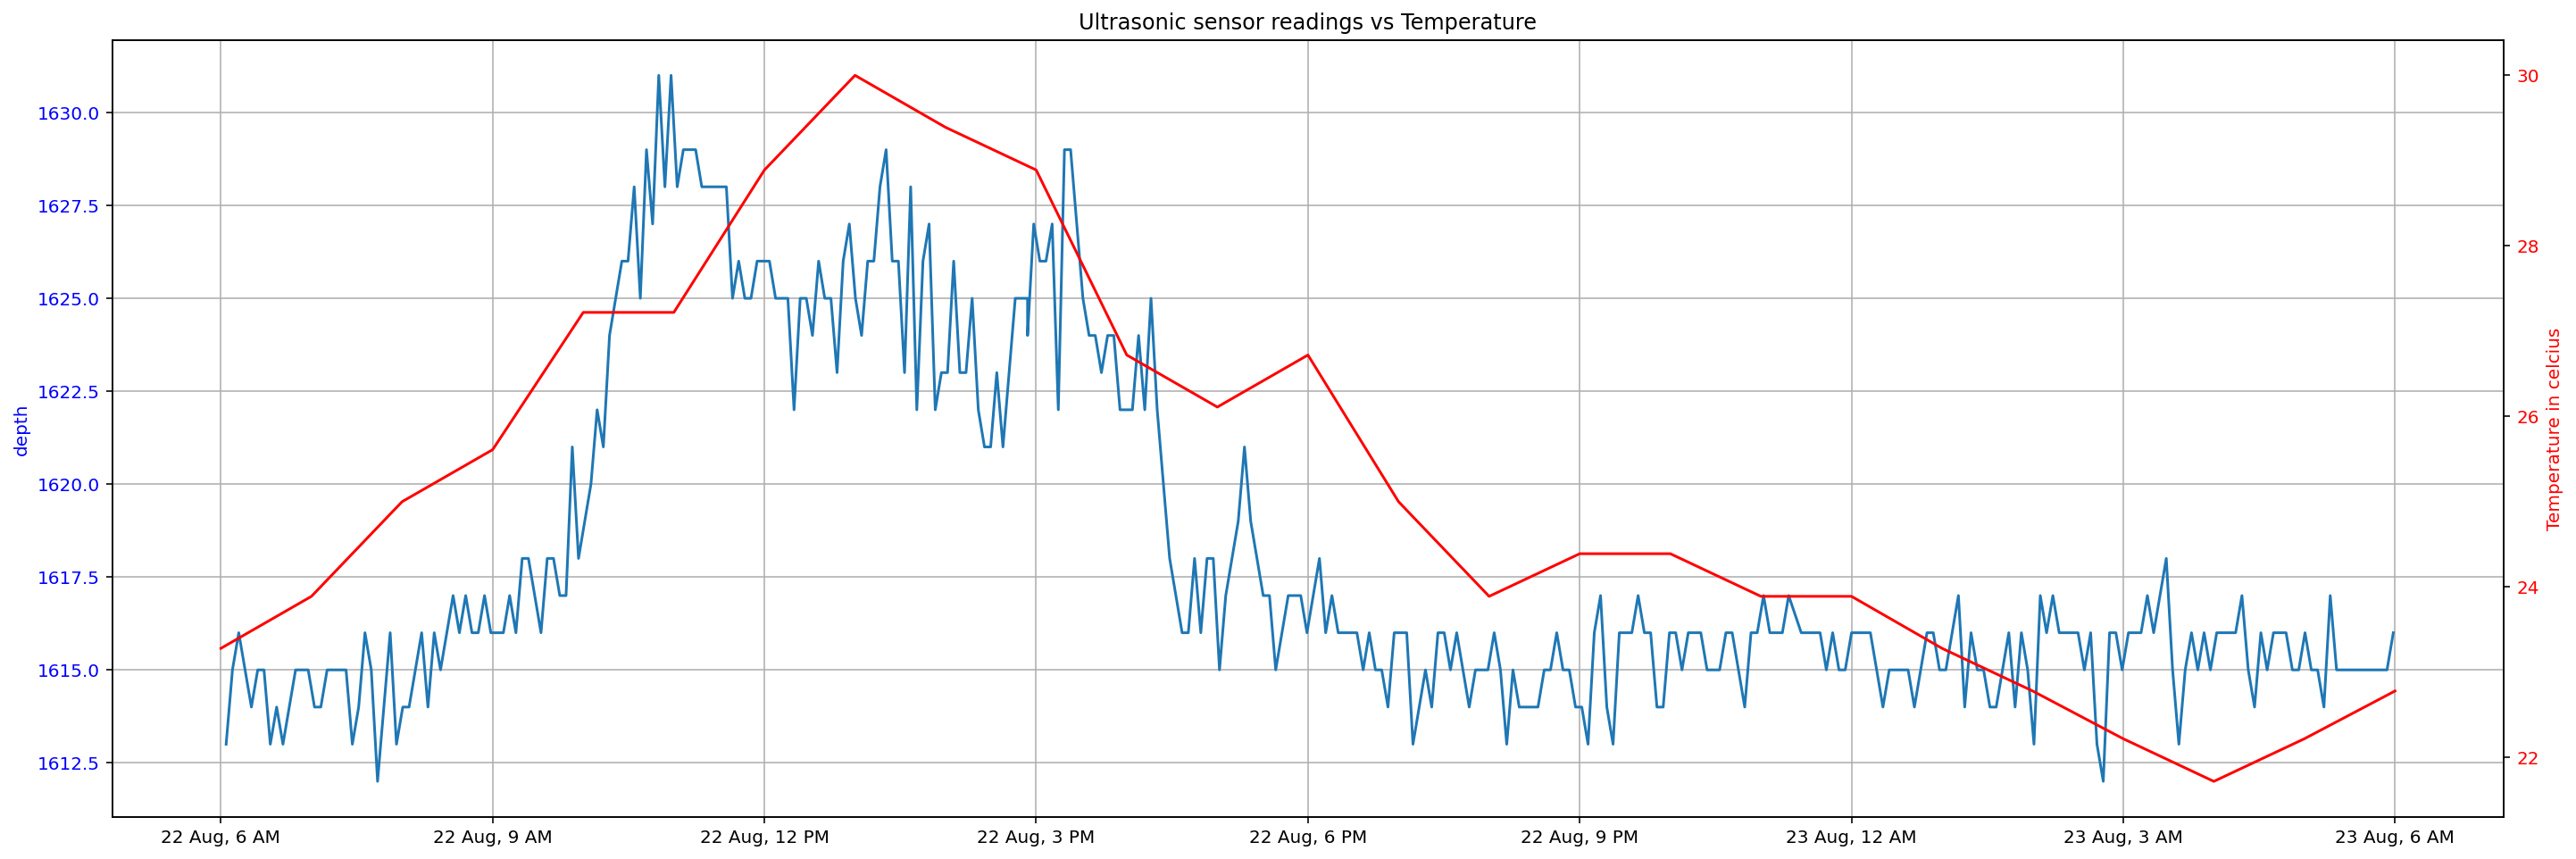

In [59]:
# Comparing Sensor data with weather data
%config InlineBackend.figure_format = 'retina'

fig, ax1 = plt.subplots(figsize = (24, 8))

a = np.arange(0,depth_readings.shape[0])
ax1.plot(depth_readings['time'], depth_readings['depth'])
ax1.set_ylabel('depth',color= 'b')
ax1.ticklabel_format(style='plain', axis='y')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.grid(True)
ax2 = ax1.twinx()
ax2.plot(aug22_weatherdata["datetime"],aug22_weatherdata["temp_celcius"], 'r-')
ax2.set_ylabel('Temperature in celcius', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.xaxis.set_major_formatter(DateFormatter('%-d %b, %-I %p', tz=tz.gettz('US/Eastern')))
ax2.ticklabel_format(style='plain', axis='y')
plt.title('Ultrasonic sensor readings vs Temperature')
plt.savefig('UltrasonicvsTemp_aug22nd.png')